In [1]:
import pandas as pd
import collections
import numpy as np
import matplotlib.pyplot as plt
np.seterr(divide='ignore', invalid='ignore')

from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

## Define functions

The function for training `QDA` :
- takes the inputs : $X_{app}$ (training input matrix $n, p$), $z_{app}$ (binary class indicator matrix $n, K$), $m_{prior}$ (Gaussian prior expectation matrix $K, p$), $df_{exp}$ (Gaussian prior shrinkage parameter), $S_{prior}$ (covariance matrix $p, p, K$ for the inverse -Wishart prior), $df_{cov}$ (degree of freedom of the inverse-Wishart prior)
- provides : $pi$ (vector $K, 1$ of class proportions), $mu$ (estimated expectation matrix $K, p$), $Sig$ (estimated covariance matrices $p, p, K$)

In [2]:
def QDA(Xapp, zapp, mprior, df_exp, Sprior, df_cov):
    n, p, K =  Xapp.shape[0], Xapp.shape[1], zapp.shape[1]
    pi = np.zeros(K)
    mu = np.zeros((K, p))
    B = np.zeros((p, p, n))
    Sig = np.zeros((p, p, K))
    
    pi = np.mean(zapp, axis=0)
    for j in range(K):
        mu[j, :] = (sum(zapp[i, j] * Xapp[i, :] for i in range(n)) 
                    + df_exp * mprior[j, :]) / (sum(zapp[:, j]) + df_exp)
        
        for i in range(n):
            temp = (Xapp[i, :] - mprior[j, :]).reshape((p, -1))
            B[:, :, i] = temp @ temp.T
        
        Sig[:, :, j] = (sum((zapp[i, j] * B[:, :, i]) for i in range(n)) + 
                        df_exp * (mu[j, :] - mprior[j, :]) @ (mu[j, :] - mprior[j, :]).T + 
                        Sprior[:, :, j].T) / (sum(zapp[:, j]) + df_cov + p + 2)
    return pi, mu, Sig

In [3]:
def QDA_without_prior(Xapp, zapp):
    n, p, K =  Xapp.shape[0], Xapp.shape[1], zapp.shape[1]
    pi = np.zeros(K)
    mu = np.zeros((K, p))
    B = np.zeros((p, p, n))
    Sig = np.zeros((p, p, K))
    
    pi = np.mean(zapp, axis=0)
    for j in range(K):
        mu[j, :] = sum(zapp[i, j] * Xapp[i, :] for i in range(n))
        
        for i in range(n):
            temp = (Xapp[i, :] - mu[j, :]).reshape((p, -1))
            
            B[:, :, i] = temp @ temp.T
        
        Sig[:, :, j] = sum((zapp[i, j] * B[:, :, i]) for i in range(n)) / sum(zapp[:, j])
    return pi, mu, Sig

The function for evaluating test set `evaluation` :
- takes the inputs : $X_{tst}$ (test input matrix $n, p$), $pi$ (vector $K, 1$ of class proportions), $mu$ (estimated expectation matrix $K, p$), $Sig$ (estimated covariance matrices $p, p, K$)
- provides : $prob$ (matrix $n, K$ of estimated class posterior probabilities) and $pred$ (vector $n, 1$ of corresponding decisions)

In [4]:
def evaluation(Xtst, pi, mu, Sig):
    n, p, K = Xtst.shape[0], Xtst.shape[1], len(pi)
    prob = np.zeros((n, K))
    pred = np.zeros(n)
    
    f = lambda x, mu, Sig: np.linalg.det(Sig)**(-1/2) * np.exp((-1/2) *(x - mu).T
                                                               @ np.linalg.inv(Sig)
                                                               @ (x - mu))
   
    for j in range(K):
        for i in range(n):
            total = sum(pi[k] * f(Xtst[i, :], mu[k, :], Sig[:, :, k]) for k in range(K))
            prob[i, j] = pi[j] * f(Xtst[i, :], mu[j, :], Sig[:, :, j]) / total
        
    pred = np.argmax(prob, axis=1)
    
    return prob, pred

We define a `data_processing` function to test different dataset. The function does respectively :
- Read the dataset by the `pandas` library and transform it to the one in form of the `numpy` library in order to facilitate our next works.
- Apply PCA filtering process to the dataset if necessary.
- Sort all classes of the dataset and display their enumeration
- Separate the dataset into training and test ones by `cut_off` coefficient predefined at `0.9`
- Calculate the prior expectation and variance based on the training set

In [5]:
def data_processing(file_url, n_components_pca=None, test_size=0.3):
    data = pd.read_csv(file_url, header=0)
    data = data.to_numpy()
    
    if n_components_pca is not None:
        data_y = data[:, -1]
        data_X = data[:, :-1]
        pca = PCA(n_components=n_components_pca)
        data_X = pca.fit_transform(data_X)
        data = np.hstack((data_X, data_y.reshape((-1,1))))
    
    classes = sorted(collections.Counter(list(data[:, -1])).keys())
    classes_with_index = {}
    
    K = len(classes)
    n, p = data.shape[0], data.shape[1] - 1
    for i_class in range(K):
        classes_with_index[i_class] = classes[i_class]
        data[data[:, -1] == classes[i_class], -1] = i_class
    print("Ours classes are enumerated as bellow : \n", classes_with_index)
    
    if test_size > 1 or test_size < 0:
        raise IndexError("invalid value of test_size")
    else:
        Xapp, Xtst, yapp, ytst = train_test_split(data[:, :-1], data[:, -1], test_size=test_size)

        Zapp = np.zeros((len(yapp), K))
        Ztst = np.zeros((len(ytst), K))
        for i in range(len(yapp)):
            Zapp[i, int(yapp[i])] = 1
        for i in range(len(ytst)):
            Ztst[i, int(ytst[i])] = 1
    
    mprior = np.zeros((K, p))
    Sprior = np.zeros((p, p, K))
    for j in range(K):
        temp = data[data[:, -1] == j, :-1]
        temp = temp.astype(float)
        mprior[j, :] = temp.mean(axis = 0)
        Sprior[:, :, j] = np.cov(temp, rowvar=False)
    return Xapp, Zapp, Xtst, Ztst, mprior, Sprior

## Optdigits test

The `optdigits` dataset has many zero elements that make itselft correlated. That's why the result from the inital training datatset is badly evaluated. We then apply a PCA filtering process with number of principal components depending on the `cut_off` coefficient (rank of training set) in order to eliminate the correlated ones. As a result, we get much better performance. <br>
For the choice of the shrinkage parameter $df_{exp}$ and the degree of freedom $df_{co}v$, we a priori choose $df_{exp} = 10$ and $df_{cov} = 300$ for this dataset and also the next ones.

In [6]:
Xapp_opt, Zapp_opt, Xtst_opt, Ztst_opt, mprior_opt, Sprior_opt = data_processing(
                                            "dataset/optdigits.csv", n_components_pca=20)

df_exp_opt = 0.1
df_cov_opt = Xapp_opt.shape[1] + 1

pi_opt, mu_opt, Sig_opt = QDA(Xapp_opt, Zapp_opt, mprior_opt, df_exp_opt, Sprior_opt, df_cov_opt)
prob_opt, pred_opt = evaluation(Xtst_opt, pi_opt, mu_opt, Sig_opt)

print('\n\n', confusion_matrix(np.argmax(Ztst_opt, axis=1), pred_opt))
print('\n\n', classification_report(np.argmax(Ztst_opt, axis=1), pred_opt))
print('\n\n', precision_score(np.argmax(Ztst_opt, axis=1), pred_opt, average='weighted'))

Ours classes are enumerated as bellow : 
 {0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0, 5: 5.0, 6: 6.0, 7: 7.0, 8: 8.0, 9: 9.0}


 [[158   0   0   0   1   1   0   0   0   0]
 [  0 175   1   1   1   0   0   0   0   1]
 [  0   0 169   0   0   0   0   0   1   0]
 [  0   0   0 168   0   2   0   0   4   1]
 [  0   0   0   0 148   0   1   0   0   0]
 [  0   0   0   1   0 176   0   0   0   1]
 [  0   1   0   0   0   0 157   0   1   0]
 [  0   0   0   0   0   0   0 171   0   0]
 [  0   0   0   0   0   0   0   0 170   0]
 [  0   0   0   0   2   0   0   1   1 171]]


               precision    recall  f1-score   support

           0       1.00      0.99      0.99       160
           1       0.99      0.98      0.99       179
           2       0.99      0.99      0.99       170
           3       0.99      0.96      0.97       175
           4       0.97      0.99      0.98       149
           5       0.98      0.99      0.99       178
           6       0.99      0.99      0.99       159
       

In [7]:
pi_opt_2, mu_opt_2, Sig_opt_2 = QDA_without_prior(Xapp_opt, Zapp_opt)
prob_opt_2, pred_opt_2 = evaluation(Xtst_opt, pi_opt_2, mu_opt_2, Sig_opt_2)

print('\n\n', confusion_matrix(np.argmax(Ztst_opt, axis=1), pred_opt_2))
print('\n\n', classification_report(np.argmax(Ztst_opt, axis=1), pred_opt_2))
print('\n\n', precision_score(np.argmax(Ztst_opt, axis=1), pred_opt_2, average='weighted'))



 [[158   0   0   0   0   1   0   0   1   0]
 [  1 176   0   1   0   0   0   0   0   1]
 [  0   0 169   0   1   0   0   0   0   0]
 [  0   1   0 167   0   0   0   0   5   2]
 [  0   0   1   0 147   0   0   0   1   0]
 [  0   0   0   0   0 176   0   0   1   1]
 [  0   1   0   0   0   0 156   0   2   0]
 [  0   0   0   0   0   1   1 169   0   0]
 [  0   0   0   3   1   0   0   0 166   0]
 [  0   0   0   1   1   0   0   1   3 169]]


               precision    recall  f1-score   support

           0       0.99      0.99      0.99       160
           1       0.99      0.98      0.99       179
           2       0.99      0.99      0.99       170
           3       0.97      0.95      0.96       175
           4       0.98      0.99      0.98       149
           5       0.99      0.99      0.99       178
           6       0.99      0.98      0.99       159
           7       0.99      0.99      0.99       171
           8       0.93      0.98      0.95       170
           9       0.9

Ours classes are enumerated as bellow : 
 {0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0, 5: 5.0, 6: 6.0, 7: 7.0, 8: 8.0, 9: 9.0}
Ours classes are enumerated as bellow : 
 {0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0, 5: 5.0, 6: 6.0, 7: 7.0, 8: 8.0, 9: 9.0}
Ours classes are enumerated as bellow : 
 {0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0, 5: 5.0, 6: 6.0, 7: 7.0, 8: 8.0, 9: 9.0}
Ours classes are enumerated as bellow : 
 {0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0, 5: 5.0, 6: 6.0, 7: 7.0, 8: 8.0, 9: 9.0}
Ours classes are enumerated as bellow : 
 {0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0, 5: 5.0, 6: 6.0, 7: 7.0, 8: 8.0, 9: 9.0}


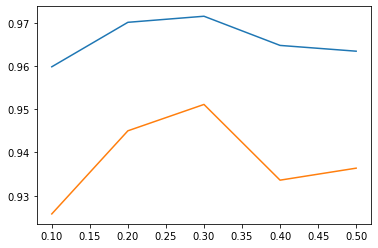

In [10]:
df_exp_opt = 0.1
df_cov_opt = Xapp_opt.shape[1] + 1
cuts_off = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
prediction = np.zeros(len(cuts_off))
prediction_without_prior = np.zeros(len(cuts_off))

for i in range(len(cuts_off)):
    Xapp_opt, Zapp_opt, Xtst_opt, Ztst_opt, mprior_opt, Sprior_opt = data_processing(
                                            "dataset/optdigits.csv", n_components_pca=10, test_size=cuts_off[i])
    
    pi_opt, mu_opt, Sig_opt = QDA(Xapp_opt, Zapp_opt, mprior_opt, df_exp_opt, Sprior_opt, df_cov_opt)
    prob_opt, pred_opt = evaluation(Xtst_opt, pi_opt, mu_opt, Sig_opt)
    prediction[i] = precision_score(np.argmax(Ztst_opt, axis=1), pred_opt, average='weighted')
    
    pi_opt_2, mu_opt_2, Sig_opt_2 = QDA_without_prior(Xapp_opt, Zapp_opt)
    prob_opt_2, pred_opt_2 = evaluation(Xtst_opt, pi_opt_2, mu_opt_2, Sig_opt_2)
    prediction_without_prior[i] = precision_score(np.argmax(Ztst_opt, axis=1), pred_opt_2, average='weighted')

plt.plot(cuts_off, prediction)
plt.plot(cuts_off, prediction_without_prior)
plt.legend(["prior", "without_prior"])

## Page Blocks test

In [20]:
df_exp_pag = 0.9
df_cov_pag = Xapp_pag.shape[1] + 1

Xapp_pag, Zapp_pag, Xtst_pag, Ztst_pag, mprior_pag, Sprior_pag = data_processing("dataset/page-blocks.csv")

pi_pag, mu_pag, Sig_pag = QDA(Xapp_pag, Zapp_pag, mprior_pag, df_exp_pag, Sprior_pag, df_cov_pag)
prob_pag, pred_pag = evaluation(Xtst_pag, pi_pag, mu_pag, Sig_pag)

print('\n\n')
print(confusion_matrix(np.argmax(Ztst_pag, axis=1), pred_pag))
print('\n\n')
print(classification_report(np.argmax(Ztst_pag, axis=1), pred_pag))
print('\n\n')
print(precision_score(np.argmax(Ztst_pag, axis=1), pred_pag, average='weighted'))

Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0}



[[1425   23    1   15   13]
 [  15   80    0    1    3]
 [   0    0    5    0    3]
 [   1    1    0   14    2]
 [  15    0    0    3   22]]



              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1477
           1       0.77      0.81      0.79        99
           2       0.83      0.62      0.71         8
           3       0.42      0.78      0.55        18
           4       0.51      0.55      0.53        40

    accuracy                           0.94      1642
   macro avg       0.70      0.75      0.71      1642
weighted avg       0.95      0.94      0.94      1642




0.9479140544161576


In [21]:
pi_pag_2, mu_pag_2, Sig_pag_2 = QDA_without_prior(Xapp_pag, Zapp_pag)
prob_pag_2, pred_pag_2 = evaluation(Xtst_pag, pi_pag_2, mu_pag_2, Sig_pag_2)

print('\n\n', confusion_matrix(np.argmax(Ztst_pag, axis=1), pred_pag_2))
print('\n\n', classification_report(np.argmax(Ztst_pag, axis=1), pred_pag_2))
print('\n\n', precision_score(np.argmax(Ztst_pag, axis=1), pred_pag_2, average='weighted'))



 [[1380   48    2   16   31]
 [   3   92    0    1    3]
 [   0    0    8    0    0]
 [   0    1    0   14    3]
 [   9    0    0    6   25]]


               precision    recall  f1-score   support

           0       0.99      0.93      0.96      1477
           1       0.65      0.93      0.77        99
           2       0.80      1.00      0.89         8
           3       0.38      0.78      0.51        18
           4       0.40      0.62      0.49        40

    accuracy                           0.93      1642
   macro avg       0.65      0.85      0.72      1642
weighted avg       0.95      0.93      0.93      1642



 0.948966400200388


Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0}
Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0}
Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0}
Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0}
Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0}


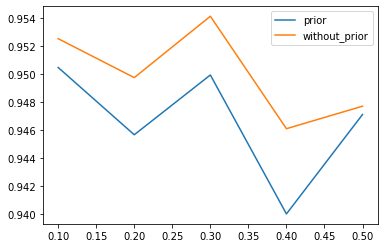

In [28]:
cuts_off = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
prediction = np.zeros(len(cuts_off))
prediction_without_prior = np.zeros(len(cuts_off))

for i in range(len(cuts_off)):
    Xapp_pag, Zapp_pag, Xtst_pag, Ztst_pag, mprior_pag, Sprior_pag = data_processing("dataset/page-blocks.csv")

    pi_pag, mu_pag, Sig_pag = QDA(Xapp_pag, Zapp_pag, mprior_pag, df_exp_pag, Sprior_pag, df_cov_pag)
    prob_pag, pred_pag = evaluation(Xtst_pag, pi_pag, mu_pag, Sig_pag)
    prediction[i] = precision_score(np.argmax(Ztst_pag, axis=1), pred_pag, average='weighted')

    pi_pag_2, mu_pag_2, Sig_pag_2 = QDA_without_prior(Xapp_pag, Zapp_pag)
    prob_pag_2, pred_pag_2 = evaluation(Xtst_pag, pi_pag_2, mu_pag_2, Sig_pag_2)
    prediction_without_prior[i] = precision_score(np.argmax(Ztst_pag, axis=1), pred_pag_2, average='weighted')

plt.plot(cuts_off, prediction)
plt.plot(cuts_off, prediction_without_prior)
plt.legend(["prior", "without_prior"])

## Satimage test

In [30]:
Xapp_sat, Zapp_sat, Xtst_sat, Ztst_sat, mprior_sat, Sprior_sat = data_processing("dataset/satimage.csv")

df_exp_sat = 0.1
df_cov_sat = Xapp_sat.shape[1] + 1

pi_sat, mu_sat, Sig_sat = QDA(Xapp_sat, Zapp_sat, mprior_sat, df_exp_sat, Sprior_sat, df_cov_sat)
prob_sat, pred_sat = evaluation(Xtst_sat, pi_sat, mu_sat, Sig_sat)

print('\n\n')
print(confusion_matrix(np.argmax(Ztst_sat, axis=1), pred_sat))
print('\n\n')
print(classification_report(np.argmax(Ztst_sat, axis=1), pred_sat))
print('\n\n')
print(precision_score(np.argmax(Ztst_sat, axis=1), pred_sat, average='weighted'))

Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0, 5: 7.0}



[[444   0   3   0   5   0]
 [  0 226   0   0   2   0]
 [  6   2 388  11   1  10]
 [  0   8  52  49   5  65]
 [  0  14   0   0 178  22]
 [  0   5  22  15  17 379]]



              precision    recall  f1-score   support

           0       0.99      0.98      0.98       452
           1       0.89      0.99      0.94       228
           2       0.83      0.93      0.88       418
           3       0.65      0.27      0.39       179
           4       0.86      0.83      0.84       214
           5       0.80      0.87      0.83       438

    accuracy                           0.86      1929
   macro avg       0.84      0.81      0.81      1929
weighted avg       0.85      0.86      0.85      1929




0.85311129953231


In [31]:
pi_sat_2, mu_sat_2, Sig_sat_2 = QDA_without_prior(Xapp_sat, Zapp_sat)
prob_sat_2, pred_sat_2 = evaluation(Xtst_sat, pi_sat_2, mu_sat_2, Sig_sat_2)

print('\n\n', confusion_matrix(np.argmax(Ztst_sat, axis=1), pred_sat_2))
print('\n\n', classification_report(np.argmax(Ztst_sat, axis=1), pred_sat_2))
print('\n\n', precision_score(np.argmax(Ztst_sat, axis=1), pred_sat_2, average='weighted'))



 [[443   1   2   1   3   2]
 [  0 225   0   0   3   0]
 [ 19   3 365  19   6   6]
 [  0  10  49  68   4  48]
 [  9  13   0   9 155  28]
 [  0   4  25  24  22 363]]


               precision    recall  f1-score   support

           0       0.94      0.98      0.96       452
           1       0.88      0.99      0.93       228
           2       0.83      0.87      0.85       418
           3       0.56      0.38      0.45       179
           4       0.80      0.72      0.76       214
           5       0.81      0.83      0.82       438

    accuracy                           0.84      1929
   macro avg       0.80      0.80      0.80      1929
weighted avg       0.83      0.84      0.83      1929



 0.8292563281297755


Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0, 5: 7.0}
Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0, 5: 7.0}
Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0, 5: 7.0}
Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0, 5: 7.0}
Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0, 5: 7.0}


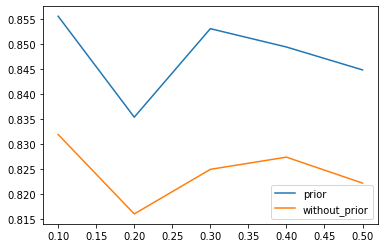

In [32]:
cuts_off = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
prediction = np.zeros(len(cuts_off))
prediction_without_prior = np.zeros(len(cuts_off))

for i in range(len(cuts_off)):
    Xapp_sat, Zapp_sat, Xtst_sat, Ztst_sat, mprior_sat, Sprior_sat = data_processing("dataset/satimage.csv")

    pi_sat, mu_sat, Sig_sat = QDA(Xapp_sat, Zapp_sat, mprior_sat, df_exp_sat, Sprior_sat, df_cov_sat)
    prob_sat, pred_sat = evaluation(Xtst_sat, pi_sat, mu_sat, Sig_sat)
    prediction[i] = precision_score(np.argmax(Ztst_sat, axis=1), pred_sat, average='weighted')

    pi_sat_2, mu_sat_2, Sig_sat_2 = QDA_without_prior(Xapp_sat, Zapp_sat)
    prob_sat_2, pred_sat_2 = evaluation(Xtst_sat, pi_sat_2, mu_sat_2, Sig_sat_2)
    prediction_without_prior[i] = precision_score(np.argmax(Ztst_sat, axis=1), pred_sat_2, average='weighted')

plt.plot(cuts_off, prediction)
plt.plot(cuts_off, prediction_without_prior)
plt.legend(["prior", "without_prior"])

## Segment test

In [42]:
Xapp_seg, Zapp_seg, Xtst_seg, Ztst_seg, mprior_seg, Sprior_seg = data_processing("dataset/segment.csv",
                                                                                n_components_pca=18)

df_exp_seg = 0.6
df_cov_seg = Xapp_seg.shape[1] + 1

pi_seg, mu_seg, Sig_seg = QDA(Xapp_seg, Zapp_seg, mprior_seg, df_exp_seg, Sprior_seg, df_cov_seg)
prob_seg, pred_seg = evaluation(Xtst_seg, pi_seg, mu_seg, Sig_seg)

print('\n\n')
print(confusion_matrix(np.argmax(Ztst_seg, axis=1), pred_seg))
print('\n\n')
print(classification_report(np.argmax(Ztst_seg, axis=1), pred_seg))
print('\n\n')
print(precision_score(np.argmax(Ztst_seg, axis=1), pred_seg, average='weighted'))

Ours classes are enumerated as bellow : 
 {0: 'brickface', 1: 'cement', 2: 'foliage', 3: 'grass', 4: 'path', 5: 'sky', 6: 'window'}



[[100   0   0   0   0   0   1]
 [  0  95   0   0   1   0   1]
 [  0   6  63   0   0   0  31]
 [  0   0   0 108   0   0   0]
 [  0   2   1   0  91   0   0]
 [  0   0   0   0   0 105   0]
 [  0  24   3   0   0   0  61]]



              precision    recall  f1-score   support

           0       1.00      0.99      1.00       101
           1       0.75      0.98      0.85        97
           2       0.94      0.63      0.75       100
           3       1.00      1.00      1.00       108
           4       0.99      0.97      0.98        94
           5       1.00      1.00      1.00       105
           6       0.65      0.69      0.67        88

    accuracy                           0.90       693
   macro avg       0.90      0.89      0.89       693
weighted avg       0.91      0.90      0.90       693




0.9100628422982215


In [43]:
pi_seg_2, mu_seg_2, Sig_seg_2 = QDA_without_prior(Xapp_seg, Zapp_seg)
prob_seg_2, pred_seg_2 = evaluation(Xtst_seg, pi_seg_2, mu_seg_2, Sig_seg_2)


print('\n\n', confusion_matrix(np.argmax(Ztst_seg, axis=1), pred_seg_2))
print('\n\n', classification_report(np.argmax(Ztst_seg, axis=1), pred_seg_2))
print('\n\n', precision_score(np.argmax(Ztst_seg, axis=1), pred_seg_2, average='weighted'))



 [[100   0   0   0   0   0   1]
 [  0  90   0   0   2   0   5]
 [  0   4  67   0   0   0  29]
 [  0   0   0 108   0   0   0]
 [  0   2   1   0  91   0   0]
 [  0   0   0   0   0 105   0]
 [  0  13   4   0   0   0  71]]


               precision    recall  f1-score   support

           0       1.00      0.99      1.00       101
           1       0.83      0.93      0.87        97
           2       0.93      0.67      0.78       100
           3       1.00      1.00      1.00       108
           4       0.98      0.97      0.97        94
           5       1.00      1.00      1.00       105
           6       0.67      0.81      0.73        88

    accuracy                           0.91       693
   macro avg       0.91      0.91      0.91       693
weighted avg       0.92      0.91      0.91       693



 0.9207347612191813


Ours classes are enumerated as bellow : 
 {0: 'brickface', 1: 'cement', 2: 'foliage', 3: 'grass', 4: 'path', 5: 'sky', 6: 'window'}
Ours classes are enumerated as bellow : 
 {0: 'brickface', 1: 'cement', 2: 'foliage', 3: 'grass', 4: 'path', 5: 'sky', 6: 'window'}
Ours classes are enumerated as bellow : 
 {0: 'brickface', 1: 'cement', 2: 'foliage', 3: 'grass', 4: 'path', 5: 'sky', 6: 'window'}
Ours classes are enumerated as bellow : 
 {0: 'brickface', 1: 'cement', 2: 'foliage', 3: 'grass', 4: 'path', 5: 'sky', 6: 'window'}
Ours classes are enumerated as bellow : 
 {0: 'brickface', 1: 'cement', 2: 'foliage', 3: 'grass', 4: 'path', 5: 'sky', 6: 'window'}


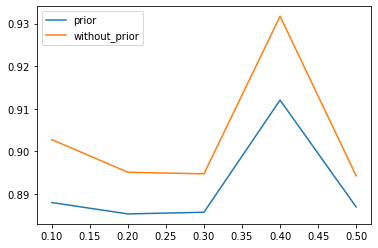

In [44]:
cuts_off = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
prediction = np.zeros(len(cuts_off))
prediction_without_prior = np.zeros(len(cuts_off))

for i in range(len(cuts_off)):
    Xapp_seg, Zapp_seg, Xtst_seg, Ztst_seg, mprior_seg, Sprior_seg = data_processing("dataset/segment.csv",
                                                                                n_components_pca=18)

    pi_seg, mu_seg, Sig_seg = QDA(Xapp_seg, Zapp_seg, mprior_seg, df_exp_seg, Sprior_seg, df_cov_seg)
    prob_seg, pred_seg = evaluation(Xtst_seg, pi_seg, mu_seg, Sig_seg)
    prediction[i] = precision_score(np.argmax(Ztst_seg, axis=1), pred_seg, average='weighted')

    pi_seg_2, mu_seg_2, Sig_seg_2 = QDA_without_prior(Xapp_seg, Zapp_seg)
    prob_seg_2, pred_seg_2 = evaluation(Xtst_seg, pi_seg_2, mu_seg_2, Sig_seg_2)
    prediction_without_prior[i] = precision_score(np.argmax(Ztst_seg, axis=1), pred_seg_2, average='weighted')

plt.plot(cuts_off, prediction)
plt.plot(cuts_off, prediction_without_prior)
plt.legend(["prior", "without_prior"])

In [14]:
# 0.9766310415063318 1;p+20 ll
# 0.9758926103474012 10;p+20
# 0.9671482548426473 10;p+300 
# v reprensent the least informative -> v high -> cov lower -> more "confident" ????
# high df_cov -> Sig =~~ sampling covariance matrix (in this case Sprior)